# CFL Code Demo and Explanation: Visual Bars 
This example demonstrates how to run a basic CFL experiment on Visual Bars Data. 


In [1]:
import numpy as np

## 1. Loading Data 

### Key Points for Loading Data
1. The data should consist of a data set `X` and a data set `Y` that are aligned (each row in `X` corresponds to the row with the same index in `Y`)
2. `X` should be the causal data set and `Y` should be the effect data 
3. For most instances of CFL, `X` and `Y` should be reshaped such that each one is a 2D array with dimensions (n_samples, n_features). Some instances of CFL require that `X` be a 4-D array.

### Load the Visual Bars Data
To create a visual bars data set, we need to import the file `generate_visual_bars_data.py`. If you are trying to generate the visual bars data from outside of the root directory of the `cfl` reposity, add the `visual_bars` directory path to the PYTHONPATH (same as you did for the `cfl` package) for easy importing. 

See the [visual bars page](https://cfl.readthedocs.io/en/latest/more_info/Visual_Bars_data.html) for background on the visual bars data set.

In [2]:
# import the file to generate visual bars data 
import visual_bars.generate_visual_bars_data as vbd

# uncomment this line and use it instead if you have added `visual_bars` to the pythonpath
# import generate_visual_bars_data as vbd

In [3]:
# In order to generate visual bars data, we set the number of images we want to generate 
# (`n_samples`), the size of each image in pixels (`im_shape`), and the intensity of random noise
# in the image (`noise_lvl`). To have reproducible results, we also will set a random seed. 

# create visual bars data 
n_samples = 5000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)


In [4]:
# We save an array of images to a variable `X` and the array of target behavior to a variable 
# `Y`. Note that `X` and `Y` are aligned - they must have the same number of observations, and 
# the nth image in `X` must correspond to the nth target value in `Y`. 

# retrieve the images and the target 
X = vb_data.getImages()
Y = vb_data.getTarget()

# X and Y have the same number of rows  
print(X.shape)
print(Y.shape)
print(X.shape[0]==Y.shape[0])



(5000, 10, 10)
(5000,)
True


## 2. Shaping the Data 
Because our `X` dataset is a set of images, we will use `CondExpCNN` for our CDE. This CDE requires that `X` be a 4-D array with dimensions `(n_samples, im_height, im_width, n_channels)` and `Y` to be 2-dimensional, with shape `(n_samples, n_features)`. 

The 'basic' CDE `CondExpMod`, which is better suited to non-spatially-organized data, requires a different input shape than `CondExpCNN`. For further guidelines about shaping your data, see [info about CDEs](https://cfl.readthedocs.io/en/latest/CDEs.html#input-shape-for-cdes). 

In [5]:
#reformat x, y into the right shape for the neural net 

# expand X 
X = np.expand_dims(X, -1) 
print(X.shape) #black and white images have just one channel

# expand Y
Y = np.expand_dims(Y, -1)
print(Y.shape)

(5000, 10, 10, 1)
(5000, 1)


## 3. Setting up the CFL Pipeline 

We will now set up an `Experiment`. The `Experiment` will create a CFL pipeline and automatically save all the parameters, results, and the trained models generated during this experiment.


CFL takes in 3 sets of parameters, each in dictionary form: 

- `data_info`  
- `CDE_params`   
- `cluster_params`   

For further details on the meaning of these parameters, consult the documentation for the clusterer and the CondExp base class. 

In this case, we use a convolutional neural net for the CDE, and K-means for clustering. Consult the documentation for the other available models. 

Note that we didn't specify some parameters, and so those parameters are given default values (values printed below). 

In [6]:
from cfl.experiment import Experiment
from sklearn.cluster import KMeans

# the parameters should be passed in dictionary form 
data_info = {'X_dims' : X.shape, 
             'Y_dims' : Y.shape, 
             'Y_type' : 'categorical' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not 
# allowed for data_info)
cnn_params = {  'filters'          : [8],
                'input_shape'      : data_info['X_dims'][1:],
                'kernel_size'      : [(4, 4)],
                'pool_size'        : [(2, 2)],
                'padding'          : ['same'],
                'conv_activation'  : ['relu'],
                'dense_units'      : 16,
                'dense_activation' : 'relu',
                'output_activation': None,

                'batch_size'  : 84, # parameters for training 
                'n_epochs'    : 20,
                'optimizer'   : 'adam',
                'loss'        : 'mean_squared_error',
                'best'        : True, 
            }

cause_cluster_params = {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0}
effect_cluster_params = {'model' : 'KMeans', 'n_clusters' : 2, 'verbose' : 0}

# steps of this CFL pipeline
block_names = ['CondExpCNN', 'CauseClusterer', 'EffectClusterer']
block_params = [cnn_params, cause_cluster_params, effect_cluster_params]

# folder to save results to 
save_path = 'visual_bars_cfl' 

# create the experiment!
my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, results_path=save_path)

All results from this run will be saved to visual_bars_cfl/experiment0002
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
show_plot not specified in input, defaulting to True
standardize not specified in input, defaulting to False
tb_path not specified in input, defaulting to None


Note that any parameters not specified will be given default values (shown in the print statements).

## 4. Training with a CFL object  

We now train the CFL object on our data. 

Training CFL pipeline.
No GPU device detected.
Train on 3750 samples, validate on 1250 samples
Epoch 1/20
3750/3750 [==============================] - 4s 1ms/sample - loss: 0.3321 - val_loss: 0.1924
Epoch 2/20
3750/3750 [==============================] - 0s 132us/sample - loss: 0.1821 - val_loss: 0.1749
Epoch 3/20
3750/3750 [==============================] - 1s 149us/sample - loss: 0.1674 - val_loss: 0.1648
Epoch 4/20
3750/3750 [==============================] - 1s 148us/sample - loss: 0.1581 - val_loss: 0.1580
Epoch 5/20
3750/3750 [==============================] - 1s 206us/sample - loss: 0.1511 - val_loss: 0.1541
Epoch 6/20
3750/3750 [==============================] - 1s 176us/sample - loss: 0.1472 - val_loss: 0.1498
Epoch 7/20
3750/3750 [==============================] - 0s 89us/sample - loss: 0.1436 - val_loss: 0.1511
Epoch 8/20
3750/3750 [==============================] - 1s 139us/sample - loss: 0.1411 - val_loss: 0.1498
Epoch 9/20
3750/3750 [==============================] - 1s 2

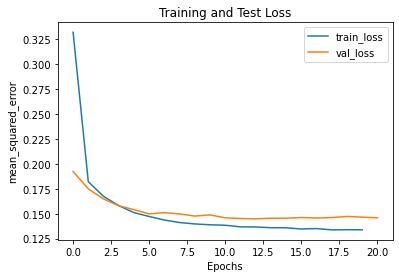

Loading parameters from  tmp_checkpoints27092021151939/best_weights
Saving parameters to  visual_bars_cfl/experiment0002/trained_blocks/CDE


In [7]:
train_results = my_exp.train()

Calling `train()` on the CFL `Experiment` results in a dictionary of dictionaries. The keys of the first dictionary correspond to the `Blocks` in the CFL pipeline. In this case (and in all cases at the moment), they are `CDE` and `Clusterer`. The keys of the inner dictionaries are the results returned by each `Block`. Below, we access the cause macrostate labels: 

In [8]:
# Below, we print the first few `x_lbls`. 
# We can see that, there are 4 classes in the data, and 
# that they are represented by the numbers `0` through `3`. Each of these labels tells us the 
# macrovariable to which the corresponding visual bars image was assigned. 

cause_cluster_results = train_results['CauseClusterer']
print(cause_cluster_results['x_lbls'][:20])

[2 1 3 3 1 1 2 0 3 1 3 3 1 2 1 3 0 3 0 3]


## 5. Optional: Predicting on a New Dataset

To predict on different data using the same, already trained CFL pipeline, we just create a second data set, and call the predict method on that new dataset.

In [9]:
n_samples = 100
im_shape = (10, 10)
noise_lvl= 0.03
random_state = 180 

# make second dataset for prediction
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X_new = vb_data.getImages()
Y_new = vb_data.getTarget()

#reformat x, y into the right shape for the neural net 
X_new_CNN = np.expand_dims(X_new, -1) 
Y_new_CNN = np.expand_dims(Y_new, -1)

# put X, Y into a new Dataset object
# and register the new dataset with the Experiment
my_exp.add_dataset(X=X_new_CNN, Y=Y_new_CNN, dataset_name='predict_data')  

# predict! 
results_new = my_exp.predict('predict_data')

In [10]:
# take a look at some of the results for the new data set 
cluster_results_new = results_new['CauseClusterer']
cluster_results_new['x_lbls'][:20]

array([1, 0, 0, 1, 1, 3, 0, 2, 1, 2, 1, 3, 1, 1, 0, 1, 2, 0, 2, 0],
      dtype=int32)

## 6. Visualize Results 

We can view some images with their predicted label using the `viewImagesandLabels()` function. 

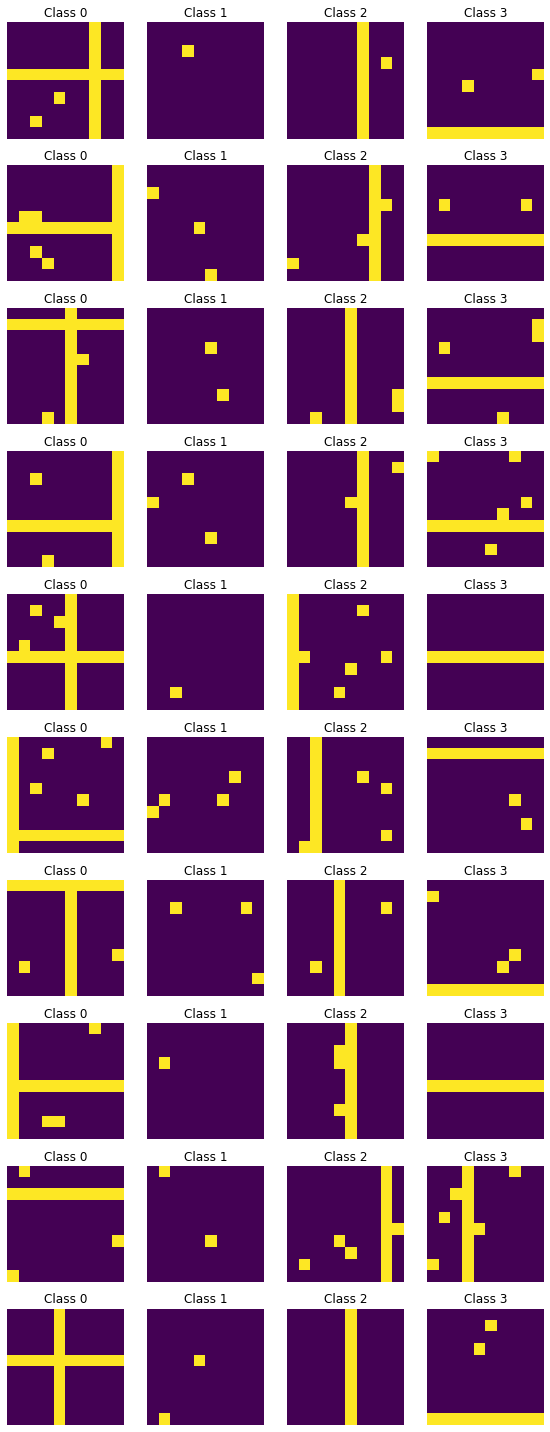

In [11]:
import cfl.visualization_methods.visual_bars_vis as vis

vis.viewImagesAndLabels(X_new, im_shape=im_shape, n_examples=10, x_lbls=cluster_results_new['x_lbls'])

## Conclusion 

As we can see, CFL has done a pretty good job of recovering the observational partitions (with some errors). For the most part, the images with a horizontal bar, a vertical bar, both, or neither, have been separated into distinct classes. Try this experiment again with a different CDE or a different sample size, and see how your results differ! 